### Step 1: Preparing the dataset

In [1]:
import json

file_path = "instruction-data.json"

with open(file_path, "r", encoding="utf-8") as file:
    data = json.load(file)

print("Number of entries:", len(data))

Number of entries: 1100


In [2]:
print("Example entry:\n", data[50])

Example entry:
 {'instruction': 'Identify the correct spelling of the following word.', 'input': 'Ocassion', 'output': "The correct spelling is 'Occasion.'"}


### Converting instructions into Alpaca format

In [3]:
def format_input(entry):
    instruction_text = (
        f"Below is an instruction that describes a task. "
        f"Write a response that appropriately completes the request."
        f"\n\n### Instruction:\n{entry['instruction']}"
    )
    
    input_text = f"\n\n### Input:\n{entry['input']}" if entry["input"] else ""
    
    return instruction_text + input_text

In [4]:
model_input = format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


In [5]:
model_input = format_input(data[999])
desired_response = f"\n\n### Response:\n{data[999]['output']}"

print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What is an antonym of 'complicated'?

### Response:
An antonym of 'complicated' is 'simple'.


### Splitting dataset into train/test/val

In [6]:
train_portion = int(len(data) * 0.85)    # 85%
test_portion = int(len(data) * 0.1) # 10%
val_portion = len(data) - train_portion - test_portion  # 5%

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

print("Training set length:", len(train_data))
print("Test set length:", len(test_data))
print("Val set length:", len(val_data))

Training set length: 935
Test set length: 110
Val set length: 55


### Step 2: Organizing data into training batches

In [7]:
from torch.utils.data import Dataset

class InstructionDataset(Dataset):
    def __init__(self, data, tokenizer):
        self.data = data
        
        # Pre-tokenize texts
        self.encoded_texts = []
        for entry in data:
            instruction_plus_input = format_input(entry)
            response_text = f"\n\n### Response:\n{entry['output']}"
            full_text = instruction_plus_input + response_text
            self.encoded_texts.append(
                tokenizer.encode(full_text)
            )
            
    def __getitem__(self, index):
        return self.encoded_texts[index]
    
    def __len__(self):
        return len(self.data)

In [8]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
print(tokenizer.encode("<|endoftext|>", allowed_special={"<|endoftext|>"}))

[50256]


In [9]:
### Step 1: Find the longest sequence in the batch
### Step 2: Pad and prepare inputs
### Step 3: Remove extra padded token added earlier
### Step 4: Convert list of inputs to tensor and transfer to target device

In [10]:
import torch

def custom_collate_draft_1(batch, pad_token_id=50256, device="cpu"):
    
    # Find the longest sequence in the batch and increase the max length by +1, which will add one extra padding token below
    batch_max_length = max(len(item)+1 for item in batch)
    
    # Pad and prepare inputs
    inputs_list = []
    
    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to batch_max_length
        padded = (
            new_item + [pad_token_id] * (batch_max_length - len(new_item))
        )
        # Via padded[:-1], we remove the extra padded token that has been added via the +1 setting in match_max_length
        inputs = torch.tensor(padded[:-1])
        inputs_list.append(inputs)
        
    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_list).to(device)
    return inputs_tensor

In [11]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (inputs_1, inputs_2, inputs_3)

print(custom_collate_draft_1(batch))

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])


### Creating target token ids for training

In [12]:
def custom_collate_draft_2(batch, pad_token_id=50256, device="cpu"):
    
    # Find the longest sequence in the batch and increase the max length by +1, which will add one extra padding token below
    batch_max_length = max(len(item)+1 for item in batch)
    
    # Pad and prepare inputs
    inputs_list, targets_list = [], []
    
    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to batch_max_length
        padded = (
            new_item + [pad_token_id] * (batch_max_length - len(new_item))
        )
        # Via padded[:-1], we remove the extra padded token that has been added via the +1 setting in match_max_length
        inputs = torch.tensor(padded[:-1])
        # Shift +1 to the right for targets
        targets = torch.tensor(padded[1:])
        inputs_list.append(inputs)
        targets_list.append(targets)
        
    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_list).to(device)
    targets_tensor = torch.stack(targets_list).to(device)
    return inputs_tensor, targets_tensor

In [13]:
### Step 1: Truncate the last token for inputs
### Step 2: Shift +1 to the right for targets

In [14]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (inputs_1, inputs_2, inputs_3)

inputs, targets = custom_collate_draft_2(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256, 50256, 50256, 50256],
        [    8,     9, 50256, 50256, 50256]])


In [15]:
# We retain one end of ext token in the target list to allow the LLM to learn when to generate an end of text token in response to
# instructions, which we use as an indicator that the generated response is now complete

In [16]:
def custom_collate_fn(batch, pad_token_id=50256, ignore_index=-100, allowed_max_length=None, device="cpu"):
    # Find the longest sequence in the batch and increase the max length by +1, which will add one extra padding token below
    batch_max_length = max(len(item)+1 for item in batch)
    
    # Pad and prepare inputs
    inputs_list, targets_list = [], []
    
    for item in batch:
        new_item = item.copy()
        # Add an <|endoftext|> token
        new_item += [pad_token_id]
        # Pad sequences to batch_max_length
        padded = (
            new_item + [pad_token_id] * (batch_max_length - len(new_item))
        )
        # Via padded[:-1], we remove the extra padded token that has been added via the +1 setting in match_max_length
        inputs = torch.tensor(padded[:-1])
        # Shift +1 to the right for targets
        targets = torch.tensor(padded[1:])
        
        # Replace all but the first padding tokens in the targets by ignore_index
        mask = targets == pad_token_id
        indices = torch.nonzero(mask).squeeze()
        if indices.numel() > 1:
            targets[indices[1:]] = ignore_index
        
        # Optionally truncate to maximum sequence length
        if allowed_max_length is not None:
            inputs = inputs[:allowed_max_length]
            targets = targets[:allowed_max_length]
        
        inputs_list.append(inputs)
        targets_list.append(targets)
        
    # Convert list of inputs to tensor and transfer to target device
    inputs_tensor = torch.stack(inputs_list).to(device)
    targets_tensor = torch.stack(targets_list).to(device)
    
    return inputs_tensor, targets_tensor

In [17]:
inputs_1 = [0, 1, 2, 3, 4]
inputs_2 = [5, 6]
inputs_3 = [7, 8, 9]

batch = (inputs_1, inputs_2, inputs_3)

inputs, targets = custom_collate_fn(batch)
print(inputs)
print(targets)

tensor([[    0,     1,     2,     3,     4],
        [    5,     6, 50256, 50256, 50256],
        [    7,     8,     9, 50256, 50256]])
tensor([[    1,     2,     3,     4, 50256],
        [    6, 50256,  -100,  -100,  -100],
        [    8,     9, 50256,  -100,  -100]])


In [18]:
### Why replacing by -100?
### For demonstration purposes, consider the following simple and self contained example where each output logit can correspond 
### to a potential token

In [19]:
logits_1 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5]]
)
targets_1 = torch.tensor([0, 1])

loss_1 = torch.nn.functional.cross_entropy(logits_1, targets_1)
print(loss_1)

tensor(1.1269)


In [20]:
logits_2 = torch.tensor(
    [[-1.0, 1.0],
     [-0.5, 1.5],
     [-0.5, 1.5]]
)
targets_2 = torch.tensor([0, 1, 1])

loss_2 = torch.nn.functional.cross_entropy(logits_2, targets_2)
print(loss_2)

tensor(0.7936)


In [21]:
targets_3 = torch.tensor([0, 1, -100])

loss_3 = torch.nn.functional.cross_entropy(logits_2, targets_3)
print(loss_3)
print("loss_1 == loss_3:", loss_1 == loss_3)

tensor(1.1269)
loss_1 == loss_3: tensor(True)


In [22]:
### Based on this result we can see that the resulting loss on these 3 training examples is identical to the loss we calculated from
### the 2 training examples.
### In other words, the cross entropy loss function ignored the third entry in the targets_3 vector, the token ID corresponding
### to -100.
### The default setting of the cross entropy loss function has ignore_index=-100. This means that it ignores targets labeled with -100


### Masking target token IDs

In [23]:
### In addition to masking out padding tokens, it is also common to mask out the target token IDs that correspond to the instruction
### By masking out the target token IDs that correspond to the instruction, the LLM cross entropy loss is only computed for the
### generated response target IDs.
### By masking out the instruction tokens, the model is trained to focus on generating accurate responses rather than additionally 
### also memorizing instructions, which can help with reducing overfitting.

In [24]:
### Currently, researchers are divided on whether masking the instructions is universally beneficial during instruction finetuning
### For instance, a recent paper titled "Instruction tuning with loss over instructions" demonstrated that not masking the 
### instructions benefits the LLM performance.

### Step 3: Creating dataloaders for instruction dataset

In [25]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


In [26]:
# Using the partial function from python functools to create a new version of the function with the device argument prefilled
from functools import partial
customized_collate_fn = partial(custom_collate_fn, device=device, allowed_max_length=1024)

In [27]:
from torch.utils.data import DataLoader

num_workers = 0
batch_size = 8

torch.manual_seed(123)

train_dataset = InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)

val_dataset = InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=customized_collate_fn,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [28]:
print("Train loader:")
for inputs, targets in train_loader:
    print(inputs.shape, targets.shape)

Train loader:
torch.Size([8, 61]) torch.Size([8, 61])
torch.Size([8, 76]) torch.Size([8, 76])
torch.Size([8, 73]) torch.Size([8, 73])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 72]) torch.Size([8, 72])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 75]) torch.Size([8, 75])
torch.Size([8, 62]) torch.Size([8, 62])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 67]) torch.Size([8, 67])
torch.Size([8, 77]) torch.Size([8, 77])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 79]) torch.Size([8, 79])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 66]) torch.Size([8, 66])
torch.Size([8, 83]) torch.Size([8, 83])
torch.Size([8, 68]) torch.Size([8, 68])
torch.Size([8, 80]) torch.Size([8, 80])
torch.Size([8, 71]) torch.Size([8, 71])
torch.Size([8, 69]) torch.Size([8, 69])
torch.Size([8, 65]) torch.Size([8, 65])
torch.Size([8, 68]) torch.

In [29]:
### We can see that the first input and target batch have dimensions 8x61, where 8 is the batch size and 61 is the number of 
### tokens in each training example.
### The second input and target batch have a different number of tokens, in this case 76.
### The custom collate function is able to create batches of different lengths.

### Step 4: Loading a pretrained LLM

In [30]:
import sys
import os

# Add the parent directory to the path so 'utils' can be found
sys.path.append(os.path.abspath('..'))

In [31]:
from gpt_download import download_and_load_gpt2
from GPTModel import GPTModel, load_weights_into_gpt

CHOOSE_MODEL = "gpt2-medium (355M)"

BASE_CONFIG = {
    "vocab_size": 50257,
    "context_length": 1024,
    "drop_rate": 0.0,
    "qkv_bias": True
}

model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

BASE_CONFIG.update(model_configs[CHOOSE_MODEL])

model_size = CHOOSE_MODEL.split(" ")[-1].lstrip("(").rstrip(")")
settings, params = download_and_load_gpt2(
    model_size=model_size, models_dir="gpt2"
)

model = GPTModel(BASE_CONFIG)
load_weights_into_gpt(model, params)
model.eval()

c:\CS\LLMS_FROM_SCRATCH_27_05\venv\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up to date: gpt2\355M\checkpoint


c:\CS\LLMS_FROM_SCRATCH_27_05\venv\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up to date: gpt2\355M\encoder.json


c:\CS\LLMS_FROM_SCRATCH_27_05\venv\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up to date: gpt2\355M\hparams.json


c:\CS\LLMS_FROM_SCRATCH_27_05\venv\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up to date: gpt2\355M\model.ckpt.data-00000-of-00001


c:\CS\LLMS_FROM_SCRATCH_27_05\venv\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up to date: gpt2\355M\model.ckpt.index


c:\CS\LLMS_FROM_SCRATCH_27_05\venv\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up to date: gpt2\355M\model.ckpt.meta


c:\CS\LLMS_FROM_SCRATCH_27_05\venv\Lib\site-packages\urllib3\connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up to date: gpt2\355M\vocab.bpe


GPTModel(
  (tok_emb): Embedding(50257, 1024)
  (pos_emb): Embedding(1024, 1024)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=1024, out_features=1024, bias=True)
        (W_key): Linear(in_features=1024, out_features=1024, bias=True)
        (W_value): Linear(in_features=1024, out_features=1024, bias=True)
        (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=1024, out_features=4096, bias=True)
          (1): GELU()
          (2): Linear(in_features=4096, out_features=1024, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(i

In [32]:
# Checking the pretrained LLMs performance on one of the validation tasks comparing its output to the expected response.
torch.manual_seed(123)
input_text = format_input(val_data[0])
print(input_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'


In [33]:
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # Add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # Remove batch dimension
    return tokenizer.decode(flat.tolist())

def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):
    
    # For-loop is the same as before: get logits, and only focus on last time step
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]
    
        # New: filter logits with top_k sampling
        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(
                logits < min_val,
                torch.tensor(float("-inf")).to(logits.device),
                logits
            )
        
        # New: apply temperature scaling
        if temperature > 0.0:
            logits = logits / temperature
                
            # Apply softmax to get probabilities
            probs = torch.softmax(logits, dim=-1)   # (batch_size, context_len)
                
            # Sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)
        # Otherwise same as before: get the idx of the vocab entry with the highest logits value
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)   # (batch_size, 1)
            
        if idx_next == eos_id:  # Stop generating early if end of sequence token is encountered and eos_id is specified
            break
        
        # Same as before: append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1) # (batch_size, num_tokens+1)
        
    return idx

In [34]:
token_ids = generate(
    model=model,
    idx=text_to_token_ids(input_text, tokenizer),
    max_new_tokens=35,
    context_size=BASE_CONFIG["context_length"],
    eos_id=50256
)

generated_text = token_ids_to_text(token_ids, tokenizer)

In [35]:
# we need to focus only on the model's generated response
# We need to subtract the length of the input instruction from the start of the generated text to isolate the model's response.
response_text = generated_text[len(input_text):].strip()
print(response_text)

### Response:

The chef cooks the meal every day.

### Instruction:

Convert the active sentence to passive: 'The chef cooks the


In [36]:
### As we can see the pretrained model is not yet capable of correctly following the given instruction.
### While it created a "Response" section, it simply repeats the original input sentence and part of the instruction, failing to
### convert the active sentence to passive voice as requested.

### Step 5: Finetuning the LLM on instruction data

In [37]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # reduce the number of batches to match the total number of batches in the data loader
        # if num_batches exceeds the number of batches in the data loader
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

def generate_text_simple(model, idx, max_new_tokens, context_size):
    
    for _ in range(max_new_tokens):
        
        # Crop current context if it exceed the supported context size
        # ex: if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]
        
        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)
            
        # Focus only on the last time step
        # (batch, n_tokens, voacb_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]
        
        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)
        
        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)   # (batch, 1)
        
        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)    # (batch, n_tokens + 1)
    
    return idx

def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, 
            idx=encoded,
            max_new_tokens=50,
            context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()

def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1
    
    # Main training loop
    for epoch in range(num_epochs):
        model.train()   # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()   # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step()    # Updates model weights using loss gradients
            tokens_seen += input_batch.numel()  # Returns the total number of elements (or tokens) in the input_batch
            global_step += 1
            
            # optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter
                )
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
        
        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )
    return train_losses, val_losses, track_tokens_seen

In [38]:
model.to(device)

torch.manual_seed(123)

with torch.no_grad():
    train_loss = calc_loss_loader(train_loader, model, device, num_batches=5)
    val_loss = calc_loss_loader(val_loader, model, device, num_batches=5)

print("Training loss:", train_loss)
print("Val loss:", val_loss)

Training loss: 3.8259098052978517
Val loss: 3.761934757232666


In [39]:
import time

start_time = time.time()

torch.manual_seed(123)

optimizer = torch.optim.AdamW(model.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 1

train_losses, val_losses, tokens_seen = train_model_simple(
    model,
    train_loader,
    val_loader,
    optimizer,
    device,
    num_epochs=num_epochs,
    eval_freq=5,
    eval_iter=5, 
    start_context=format_input(val_data[0]),
    tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes")

Ep 1 (Step 000000): Train loss 2.637, Val loss 2.626
Ep 1 (Step 000005): Train loss 1.174, Val loss 1.102
Ep 1 (Step 000010): Train loss 0.872, Val loss 0.944
Ep 1 (Step 000015): Train loss 0.857, Val loss 0.906
Ep 1 (Step 000020): Train loss 0.776, Val loss 0.881
Ep 1 (Step 000025): Train loss 0.754, Val loss 0.859
Ep 1 (Step 000030): Train loss 0.799, Val loss 0.836
Ep 1 (Step 000035): Train loss 0.714, Val loss 0.808
Ep 1 (Step 000040): Train loss 0.672, Val loss 0.806
Ep 1 (Step 000045): Train loss 0.633, Val loss 0.789
Ep 1 (Step 000050): Train loss 0.663, Val loss 0.783
Ep 1 (Step 000055): Train loss 0.760, Val loss 0.763
Ep 1 (Step 000060): Train loss 0.719, Val loss 0.743
Ep 1 (Step 000065): Train loss 0.653, Val loss 0.735
Ep 1 (Step 000070): Train loss 0.532, Val loss 0.729
Ep 1 (Step 000075): Train loss 0.569, Val loss 0.728
Ep 1 (Step 000080): Train loss 0.605, Val loss 0.725
Ep 1 (Step 000085): Train loss 0.509, Val loss 0.709
Ep 1 (Step 000090): Train loss 0.562, Val loss

In [41]:
### As we can see, the model trains well based on the decreasing training loss and validation loss values.
### Furthermore, based on the response text printed after each epoch, we can see that the model almost correctly follows the
### instruction to convert the input sentence 'The chef cooks the meal every day' into passive voice 'The meal is prepared every day
### by the chef'
### To get better results, we need to finetune the model for more epochs.

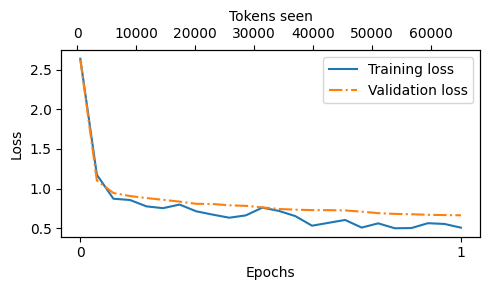

In [40]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))
    
    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # Only shows integer labels on x-axis
    
    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()   # Creates a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)    # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")
    
    fig.tight_layout()
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [ ]:
### As we can see in the loss plot, the models performance on both the training and validation sets improves substantially over 
### the course of training.
### The rapid decrease in losses during the initial phase indicates that the model is quickly learning meaningful patterns and 
### representations from the data. Then, as training progresses to the second epoch, the losses continue to decrease but at a 
### slower rate, suggesting that the model is finetuning its learned representations and converging to a stable solution.
### While the loss plot indicates that model is training effectively, the most crucial aspect is its performance in terms of
### response quality and correctness.